# Olist E-commerce Data Analysis

## Import & Check Missing Vaules

In [3]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

In [4]:
# Import data
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
category_name = pd.read_csv("product_category_name_translation.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")

In [5]:
# Check Missing Values
# dfs = [customers, orders, order_payments, order_items, products, category_name, sellers, geolocation]
# for i in dfs:
#    print(i.info())

# There are missing values in orders and products table

# Check the proportion of missing values
orders_proportion_missing = orders.isnull().any(axis=1).sum() / len(orders)
products_proportion_missing = products.isnull().any(axis=1).sum() / len(products)

# Print the proportion as a percentage
print(f"Proportion of rows with missing values in orders table: {orders_proportion_missing:.2%}")
print(f"Proportion of rows with missing values in products table: {products_proportion_missing:.2%}")

Proportion of rows with missing values in orders table: 3.00%
Proportion of rows with missing values in products table: 1.85%


In [6]:
# The proportion of rows with missing values is less than 5%. Therefore, I decide to drop the rows with missing values.
orders = orders.dropna()
products = products.dropna()

In [7]:
# Import each table into SQLite
engine = create_engine('sqlite://', echo=False)
customers.to_sql('customers', con=engine, index=False, if_exists='replace')
geolocation.to_sql('geolocation', con=engine, index=False, if_exists='replace')
order_items.to_sql('order_items', con=engine, index=False, if_exists='replace')
order_payments.to_sql('order_payments', con=engine, index=False, if_exists='replace')
orders.to_sql('orders', con=engine, index=False, if_exists='replace')
products.to_sql('products', con=engine, index=False, if_exists='replace')
sellers.to_sql('sellers', con=engine, index=False, if_exists='replace')
category_name.to_sql('category_name', con=engine, index=False, if_exists='replace')

71

## 1. Sales Analysis

### Revenue & Orders Insights

#### 1. What is the total revenue generated over time (monthly, quarterly, or yearly)?

In [11]:
# quarterly
merge_table_1 = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items
    ON orders.order_id = order_items.order_id
)
SELECT  CONCAT(STRFTIME('%Y', order_purchase_timestamp), '-Q', CAST((STRFTIME('%m', order_purchase_timestamp) + 2) / 3 AS INTEGER)) AS year_quarter,
        SUM(price + freight_value) AS total_rev,
        COUNT(order_status) AS number_of_orders,
        SUM(price + freight_value)/COUNT(order_status) AS avg_rev
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY year_quarter
ORDER BY year_quarter
LIMIT 100
"""
quarterly_revenue = pd.read_sql_query(merge_table_1, engine)
quarterly_revenue.head()

,year_quarter,total_rev,number_of_orders,avg_rev
0,2016-Q3,143.46,3,47.820000
1,2016-Q4,46510.28,314,148.121911
2,2017-Q1,811098.04,5653,143.480991
3,2017-Q2,1447520.17,10061,143.874383
4,2017-Q3,1913014.95,13949,137.143519


In [12]:
# monthly
merge_table_2 = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items
    ON orders.order_id = order_items.order_id
)
SELECT    CONCAT(strftime('%Y', order_purchase_timestamp), '-', strftime('%m', order_purchase_timestamp)) AS year_month,
        SUM(price + freight_value) AS total_rev,
        COUNT(order_status) AS number_of_orders,
        SUM(price + freight_value)/COUNT(order_status) AS avg_rev
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY year_month
ORDER BY year_month
LIMIT 100
"""
monthly_revenue = pd.read_sql_query(merge_table_2, engine)
monthly_revenue.head()

,year_month,total_rev,number_of_orders,avg_rev
0,2016-09,143.46,3,47.820000
1,2016-10,46490.66,313,148.532460
2,2016-12,19.62,1,19.620000
3,2017-01,127367.44,911,139.810582
4,2017-02,269399.65,1845,146.016070


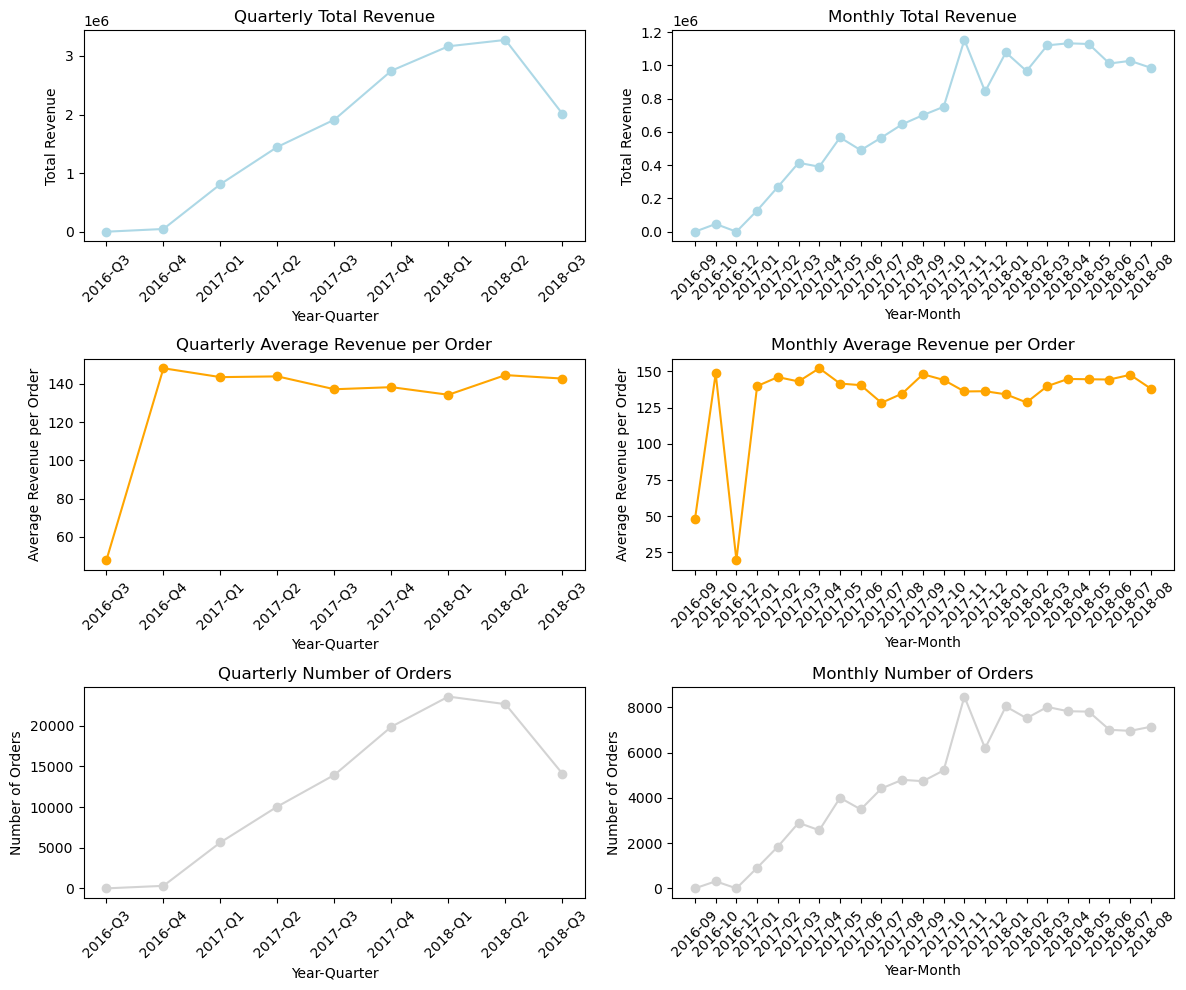

In [13]:
# Set up the 6 plots
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=False)

# Plot 1: Quarterly Total Revenue
axes[0, 0].plot(quarterly_revenue['year_quarter'], quarterly_revenue['total_rev'], marker='o', color='lightblue')
axes[0, 0].set_title("Quarterly Total Revenue")
axes[0, 0].set_xlabel("Year-Quarter")
axes[0, 0].set_ylabel("Total Revenue")
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Quarterly Average Revenue per Orders
axes[1, 0].plot(quarterly_revenue['year_quarter'], quarterly_revenue['avg_rev'], marker='o', color='orange')
axes[1, 0].set_title("Quarterly Average Revenue per Order")
axes[1, 0].set_xlabel("Year-Quarter")
axes[1, 0].set_ylabel("Average Revenue per Order")
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 3: Quarterly Number of Orders
axes[2, 0].plot(quarterly_revenue['year_quarter'], quarterly_revenue['number_of_orders'], marker='o', color='lightgray')
axes[2, 0].set_title("Quarterly Number of Orders")
axes[2, 0].set_xlabel("Year-Quarter")
axes[2, 0].set_ylabel("Number of Orders")
axes[2, 0].tick_params(axis='x', rotation=45)

# Plot 4: Monthly Total Revenue
axes[0, 1].plot(monthly_revenue['year_month'], monthly_revenue['total_rev'], marker='o', color='lightblue')
axes[0, 1].set_title("Monthly Total Revenue")
axes[0, 1].set_xlabel("Year-Month")
axes[0, 1].set_ylabel("Total Revenue")
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 5: Monthly Average Revenue per Orders
axes[1, 1].plot(monthly_revenue['year_month'], monthly_revenue['avg_rev'], marker='o', color='orange')
axes[1, 1].set_title("Monthly Average Revenue per Order")
axes[1, 1].set_xlabel("Year-Month")
axes[1, 1].set_ylabel("Average Revenue per Order")
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot 6: Monthly Number of Orders
axes[2, 1].plot(monthly_revenue['year_month'], monthly_revenue['number_of_orders'], marker='o', color='lightgray')
axes[2, 1].set_title("Monthly Number of Orders")
axes[2, 1].set_xlabel("Year-Month")
axes[2, 1].set_ylabel("Number of Orders")
axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 2. Which product categories contribute the most to revenue and the highest number of orders?

In [15]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items
        ON orders.order_id = order_items.order_id
    INNER JOIN products
        ON order_items.product_id = products.product_id
    INNER JOIN category_name
        ON products.product_category_name = category_name.product_category_name
)
SELECT  
    product_category_name_english AS category,
    SUM(price + freight_value) AS total_revenue,
    COUNT(DISTINCT order_id) AS order_counts
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
ORDER BY order_counts DESC
LIMIT 100
"""

product_sales_by_category = pd.read_sql_query(merge_table, engine)

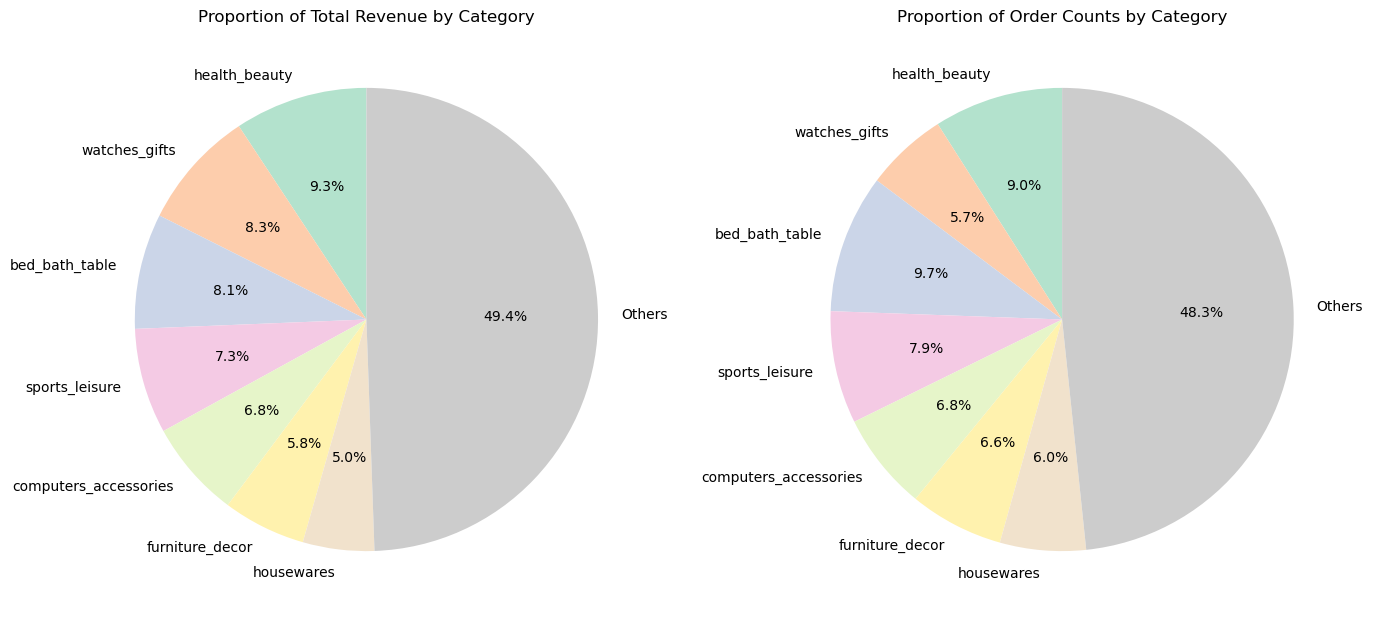

In [16]:
# Get top 7 categories by total revenue
top_revenue_categories = product_sales_by_category.nlargest(7, 'total_revenue')

# Group all other categories into 'Others'
other_revenue_df = product_sales_by_category.loc[~product_sales_by_category['category'].isin(top_revenue_categories['category'])]
other_revenue = other_revenue_df['total_revenue'].sum()
other_order_counts = other_revenue_df['order_counts'].sum()

# Create 'Others' category for total revenue
others_revenue_df = pd.DataFrame({
    'category': ['Others'],
    'total_revenue': [other_revenue],
    'order_counts': [other_order_counts]  # Adjust based on what you want for 'Others'
})

# Combine the top categories with 'Others'
top_revenue_categories = pd.concat([top_revenue_categories, others_revenue_df], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot pie chart for Total Revenue by Category
axes[0].pie(top_revenue_categories['total_revenue'], 
            labels=top_revenue_categories['category'], 
            autopct='%1.1f%%', startangle=90, 
            colors=plt.cm.Pastel2.colors, 
            textprops={'fontsize': 10})

axes[0].set_title('Proportion of Total Revenue by Category')

# Plot pie chart for Order Counts by Category
axes[1].pie(top_revenue_categories['order_counts'], 
            labels=top_revenue_categories['category'], 
            autopct='%1.1f%%', startangle=90, 
            colors=plt.cm.Pastel2.colors, 
            textprops={'fontsize': 10})

axes[1].set_title('Proportion of Order Counts by Category')

plt.tight_layout()
plt.show()

In [17]:
# Deep Dive into the top 10 categories
product_sales_by_category_top_revenue = product_sales_by_category.sort_values(by='total_revenue',ascending=False).head(10)
product_sales_by_category_top_revenue['total_revenue_k'] = product_sales_by_category_top_revenue['total_revenue'] / 1000
product_sales_by_category_top_orders = product_sales_by_category.sort_values(by='order_counts',ascending=False).head(10)

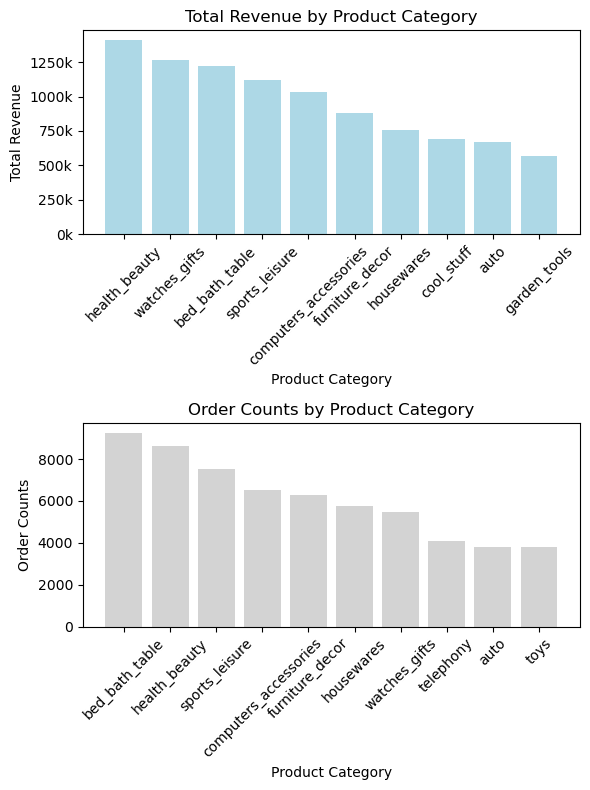

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# Plot Total Revenue by Product Category
axes[0].bar(product_sales_by_category_top_revenue['category'], 
            product_sales_by_category_top_revenue['total_revenue_k'], 
            color='lightblue')

axes[0].set_xlabel('Product Category')
axes[0].set_ylabel('Total Revenue')
axes[0].set_title('Total Revenue by Product Category')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}k'))
axes[0].tick_params(axis='x', rotation=45)

# Plot Order Counts by Product Category
axes[1].bar(product_sales_by_category_top_orders['category'], 
            product_sales_by_category_top_orders['order_counts'], 
            color='lightgray')

axes[1].set_xlabel('Product Category')
axes[1].set_ylabel('Order Counts')
axes[1].set_title('Order Counts by Product Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 3. Which sellers contribute the most to revenue and the highest number of orders?

In [20]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items
        ON orders.order_id = order_items.order_id
    INNER JOIN sellers
        ON order_items.seller_id = sellers.seller_id
)
SELECT  
    seller_id,
    SUM(price + freight_value) AS total_revenue,
    COUNT(DISTINCT order_id) AS order_counts,
    COUNT(DISTINCT product_id) AS no_unique_products
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY seller_id
ORDER BY order_counts DESC
LIMIT 100
"""

product_sales_by_seller = pd.read_sql_query(merge_table, engine)
product_sales_by_seller_top_10 = product_sales_by_seller.head(10)

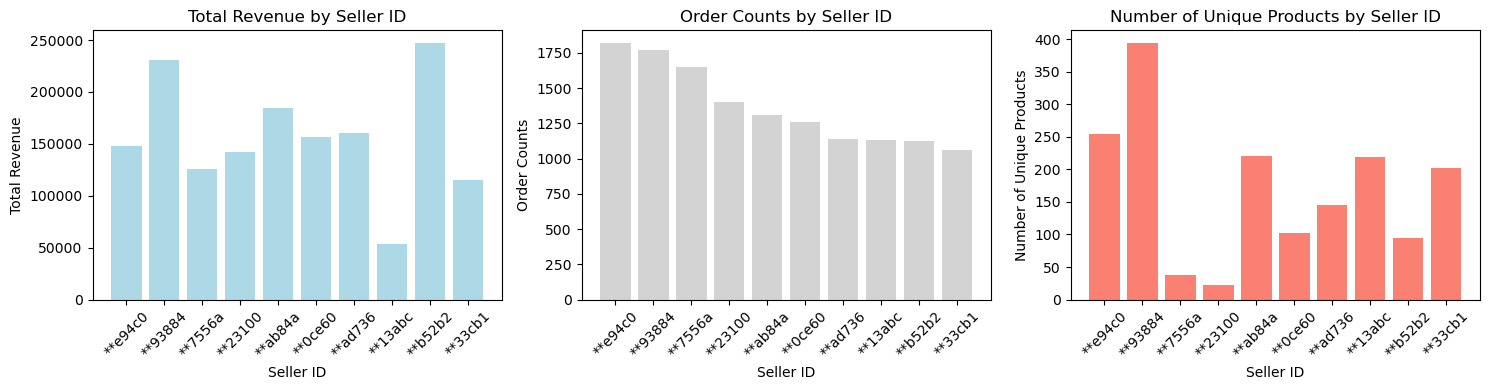

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Custom x-ticks labels to be the last 5 digits of seller_id with ** prefix
xticks = [f"**{str(seller_id)[-5:]}" for seller_id in product_sales_by_seller_top_10['seller_id']]

# Plot Total Revenue by Seller ID
axes[0].bar(product_sales_by_seller_top_10['seller_id'], 
            product_sales_by_seller_top_10['total_revenue'], 
            color='lightblue')

axes[0].set_xlabel('Seller ID')
axes[0].set_ylabel('Total Revenue')
axes[0].set_title('Total Revenue by Seller ID')

axes[0].set_xticks(product_sales_by_seller_top_10['seller_id'])
axes[0].set_xticklabels(xticks, rotation=45)

# Plot Order Counts by Seller ID
axes[1].bar(product_sales_by_seller_top_10['seller_id'], 
            product_sales_by_seller_top_10['order_counts'], 
            color='lightgray')

axes[1].set_xlabel('Seller ID')
axes[1].set_ylabel('Order Counts')
axes[1].set_title('Order Counts by Seller ID')

axes[1].set_xticks(product_sales_by_seller_top_10['seller_id'])
axes[1].set_xticklabels(xticks, rotation=45)

# Plot Number of Unique Products by Seller ID
axes[2].bar(product_sales_by_seller_top_10['seller_id'], 
            product_sales_by_seller_top_10['no_unique_products'], 
            color='salmon')

axes[2].set_xlabel('Seller ID')
axes[2].set_ylabel('Number of Unique Products')
axes[2].set_title('Number of Unique Products by Seller ID')

axes[2].set_xticks(product_sales_by_seller_top_10['seller_id'])
axes[2].set_xticklabels(xticks, rotation=45)

plt.tight_layout()
plt.show()

#### 4. How do payment types (credit card, voucher, etc.) impact revenue and number of orders?

In [23]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items
        ON orders.order_id = order_items.order_id
    INNER JOIN order_payments
        ON order_items.order_id = order_payments.order_id
        )
SELECT  
    payment_type,
    SUM(price + freight_value) AS total_revenue,
    COUNT(DISTINCT order_id) AS order_counts
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY payment_type
ORDER BY order_counts DESC
LIMIT 100
"""

product_sales_by_payment_type = pd.read_sql_query(merge_table, engine)
product_sales_by_payment_type

,payment_type,total_revenue,order_counts
0,credit_card,12380032.84,74296
1,boleto,2767978.11,19177
2,voucher,754212.72,3679
3,debit_card,208267.89,1484


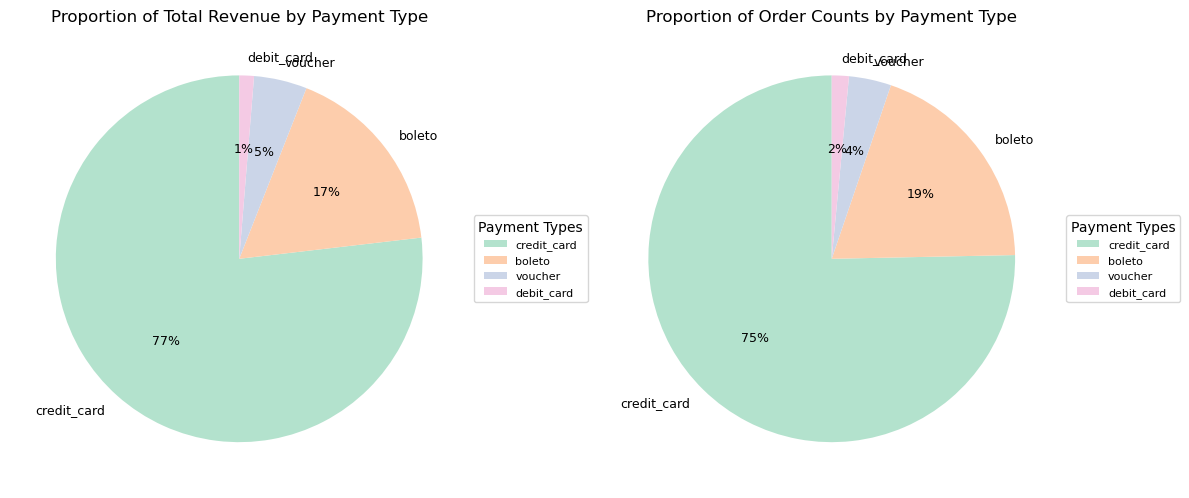

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), sharex=False)

# Plot pie chart for Total Revenue by Payment Type
axes[0].pie(
    product_sales_by_payment_type['total_revenue'], 
    labels=product_sales_by_payment_type['payment_type'],
    autopct='%1.0f%%', startangle=90, 
    colors=plt.cm.Pastel2.colors, 
    textprops={'fontsize': 9} 
)

axes[0].legend(
    product_sales_by_payment_type['payment_type'], 
    title="Payment Types", loc="center left", 
    bbox_to_anchor=(1, 0.5), fontsize=8
)

axes[0].set_title('Proportion of Total Revenue by Payment Type')

# Plot pie chart for Order Counts by Payment Type
axes[1].pie(
    product_sales_by_payment_type['order_counts'], 
    labels=product_sales_by_payment_type['payment_type'],
    autopct='%1.0f%%', startangle=90, 
    colors=plt.cm.Pastel2.colors, 
    textprops={'fontsize': 9}
)

axes[1].legend(
    product_sales_by_payment_type['payment_type'], 
    title="Payment Types", loc="center left", 
    bbox_to_anchor=(1, 0.5), fontsize=8
)

axes[1].set_title('Proportion of Order Counts by Payment Type')

plt.tight_layout()
plt.show()

### Product Performance

#### 1. What is the average price of products sold across different categories?

In [27]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM order_items
    INNER JOIN products
        ON order_items.product_id = products.product_id
    INNER JOIN category_name
        ON products.product_category_name = category_name.product_category_name
        )
SELECT  
    product_category_name_english AS category,
    AVG(price) AS avg_price
FROM merged_data
GROUP BY product_category_name_english
ORDER BY avg_price DESC
"""

avg_price_by_category = pd.read_sql_query(merge_table, engine)
avg_price_by_category

,category,avg_price
0,computers,1098.340542
1,small_appliances_home_oven_and_coffee,624.285658
2,home_appliances_2,476.124958
3,agro_industry_and_commerce,342.124858
4,musical_instruments,281.616000
...,...,...
66,food_drink,54.602446
67,cds_dvds_musicals,52.142857
68,diapers_and_hygiene,40.194615
69,flowers,33.637576


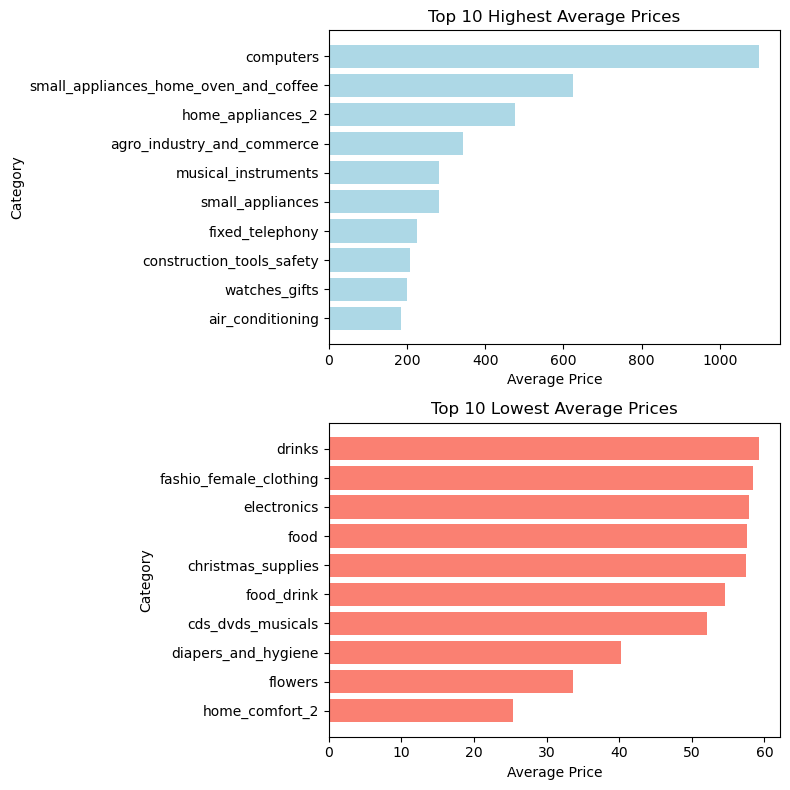

In [28]:
# Sort the dataframe for the top 10 highest average prices
top_10_highest = avg_price_by_category.nlargest(10, 'avg_price')
top_10_highest = top_10_highest.sort_values(by='avg_price', ascending=True)
# Sort the dataframe for the top 10 lowest average prices
top_10_lowest = avg_price_by_category.nsmallest(10, 'avg_price')

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Plot for top 10 highest average prices
axes[0].barh(top_10_highest['category'], top_10_highest['avg_price'], color='lightblue')
axes[0].set_xlabel('Average Price')
axes[0].set_ylabel('Category')
axes[0].set_title('Top 10 Highest Average Prices')

# Plot for top 10 lowest average prices
axes[1].barh(top_10_lowest['category'], top_10_lowest['avg_price'], color='salmon')
axes[1].set_xlabel('Average Price')
axes[1].set_ylabel('Category')
axes[1].set_title('Top 10 Lowest Average Prices')

plt.tight_layout()
plt.show()

#### 2. How many unique products are in each category?

In [30]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM order_items
    INNER JOIN products
        ON order_items.product_id = products.product_id
    INNER JOIN category_name
        ON products.product_category_name = category_name.product_category_name
        )
SELECT  
    product_category_name_english AS category,
    COUNT (DISTINCT product_id) AS unique_products_counts
FROM merged_data
GROUP BY product_category_name_english
ORDER BY unique_products_counts DESC
"""

count_unique_products_by_category = pd.read_sql_query(merge_table, engine)
count_unique_products_by_category_top = count_unique_products_by_category.head(10)

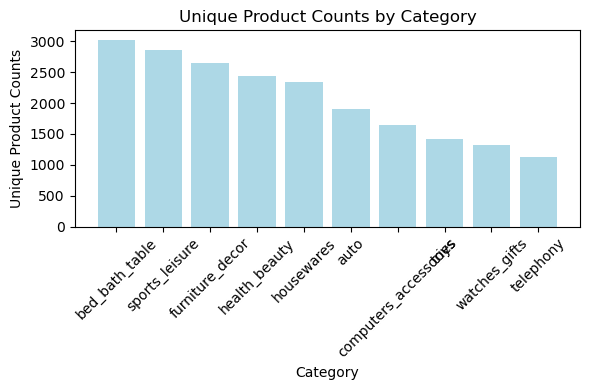

In [31]:
plt.figure(figsize=(6, 4))

# Plotting the order counts
plt.bar(count_unique_products_by_category_top['category'], 
        count_unique_products_by_category_top['unique_products_counts'], 
        color='lightblue')

plt.xlabel('Category')
plt.ylabel('Unique Product Counts')
plt.title('Unique Product Counts by Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Customer Insights

#### 1. Where are the most frequent customers (based on order count)?

In [34]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items 
    ON orders.order_id = order_items.order_id
    INNER JOIN customers
    ON orders.customer_id = customers.customer_id)
SELECT customer_id,
    COUNT(DISTINCT order_id) AS order_counts
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY customer_unique_id
ORDER BY order_counts DESC
"""

count_orders_by_customer = pd.read_sql_query(merge_table, engine)
count_orders_by_customer_top_10 = count_orders_by_customer.head(10)
count_orders_by_customer_top_10

,customer_id,order_counts
0,897b7f72042714efaa64ac306ba0cafc,15
1,e68e6423401e85c138229b23d4bf4761,9
2,dc7dc47999d1b3c4c2f6a085a1a76eef,7
3,91bd4ed51ee3835599963b967d9b9bbc,7
4,fff7466a253c0e59499ea943462c10f9,7
5,36b978fee6782172875b2f50f047f475,6
6,73a3e120dc538ab196508572c13520b1,6
7,7d1219e8f53f6b445b3d230c0794e337,6
8,5daf8c734e89f88e5305f9283e7ca135,6
9,ed1793d2d1e4175d5846ce7ebb4a01f5,6


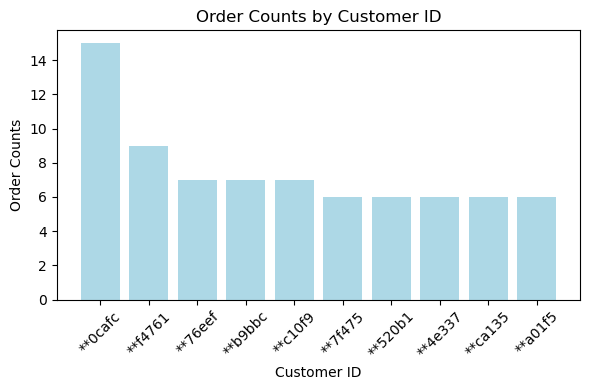

In [35]:
plt.figure(figsize=(6, 4))

# Plotting the order counts
plt.bar(count_orders_by_customer_top_10['customer_id'], 
        count_orders_by_customer_top_10['order_counts'], 
        color='lightblue')

plt.xlabel('Customer ID')
plt.ylabel('Order Counts')
plt.title('Order Counts by Customer ID')

# Custom x-ticks labels to be the last 5 digits of customer_id with ** prefix
xticks = [f"**{str(customer_id)[-5:]}" for customer_id in count_orders_by_customer_top_10['customer_id']]
plt.xticks(ticks=range(len(xticks)), labels=xticks, rotation=45)

plt.tight_layout()
plt.show()

#### 2. Which states or cities contribute most to the revenue and the highest number of orders?

In [37]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items 
    ON orders.order_id = order_items.order_id
    INNER JOIN customers
    ON orders.customer_id = customers.customer_id)
SELECT customer_city,
    SUM(price+freight_value) AS total_rev,
    COUNT(DISTINCT order_id) AS order_counts
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY customer_city
"""

count_orders_by_city = pd.read_sql_query(merge_table, engine)
count_orders_by_city_top_revenue = count_orders_by_city.head(10).sort_values(by='total_rev',ascending=False)
count_orders_by_city_top_revenue['total_rev_k'] = count_orders_by_city_top_revenue['total_rev'] / 1000
count_orders_by_city_top_orders = count_orders_by_city.head(10).sort_values(by='order_counts',ascending=False)

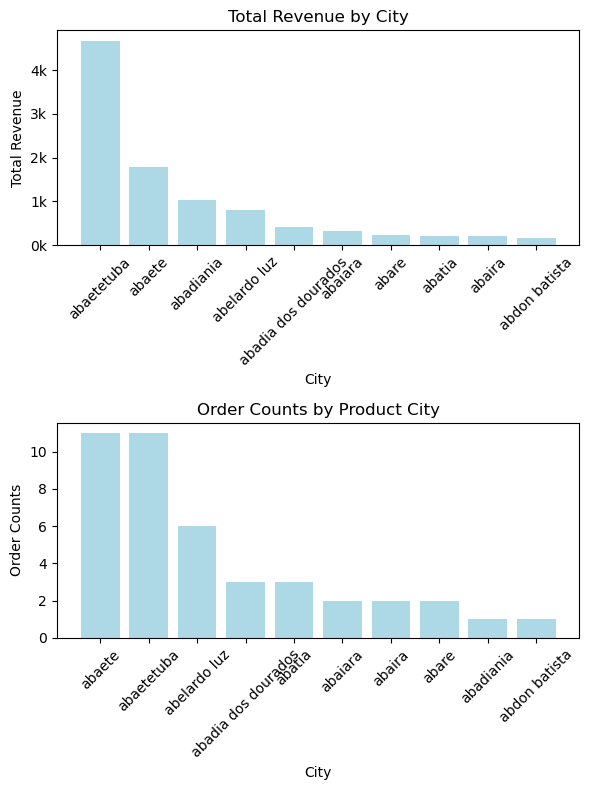

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# Plot Total Revenue by Product Category
axes[0].bar(count_orders_by_city_top_revenue['customer_city'], 
            count_orders_by_city_top_revenue['total_rev_k'], 
            color='lightblue')

axes[0].set_xlabel('City')
axes[0].set_ylabel('Total Revenue')
axes[0].set_title('Total Revenue by City')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}k'))

axes[0].tick_params(axis='x', rotation=45)

# Plot Order Counts by Product Category
axes[1].bar(count_orders_by_city_top_orders['customer_city'], 
            count_orders_by_city_top_orders['order_counts'], 
            color='lightblue')

axes[1].set_xlabel('City')
axes[1].set_ylabel('Order Counts')
axes[1].set_title('Order Counts by Product City')

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 3. What is the average revenue per order and number of items per order?

In [40]:
merge_table = """
WITH merged_data AS (
    SELECT *
    FROM orders
    INNER JOIN order_items 
    ON orders.order_id = order_items.order_id
)
SELECT 
    SUM(price + freight_value) / COUNT(DISTINCT order_id) AS avg_revenue_per_order,
    COUNT(product_id) / COUNT(DISTINCT order_id) AS avg_items_per_order
FROM merged_data
WHERE order_status = 'delivered'
"""

avg_rev_and_items_per_order = pd.read_sql_query(merge_table, engine)
avg_rev_and_items_per_order

,avg_revenue_per_order,avg_items_per_order
0,159.828379,1


## 2. Delivery Analysis

### Delivery Performance

#### 1. What is the average delivery time (from order_approved_at to order_delivered_customer_date)?

In [44]:
# monthly
merge_table = """
SELECT  CONCAT(strftime('%Y', order_purchase_timestamp), '-', strftime('%m', order_purchase_timestamp)) AS year_month,
        AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_approved_at)) AS avg_delivery_time
FROM orders
WHERE order_status = 'delivered'
GROUP BY year_month
ORDER BY year_month
"""
monthly_delivery_time = pd.read_sql_query(merge_table, engine)
monthly_delivery_time.head()

,year_month,avg_delivery_time
0,2016-09,54.813194
1,2016-10,18.728340
2,2016-12,4.682720
3,2017-01,12.146351
4,2017-02,12.777221


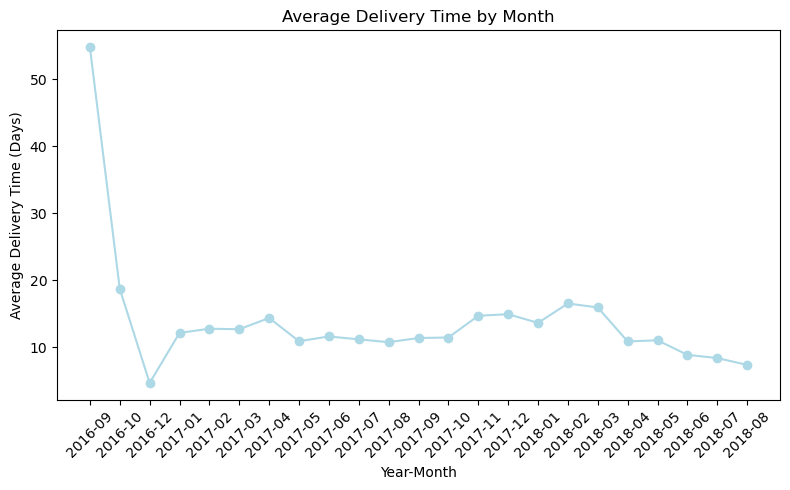

In [45]:
# Set up the figure and axis
plt.figure(figsize=(8, 5))

# Plotting the average delivery time as a line plot
plt.plot(monthly_delivery_time['year_month'], 
         monthly_delivery_time['avg_delivery_time'], 
         color='lightblue', marker='o', linestyle='-')

plt.xlabel('Year-Month')
plt.ylabel('Average Delivery Time (Days)')
plt.title('Average Delivery Time by Month')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### 2. How often are orders delivered late (after the estimated delivery date)?

In [47]:
# monthly
merge_table = """
SELECT  
    CONCAT(strftime('%Y', order_purchase_timestamp), '-', strftime('%m', order_purchase_timestamp)) AS year_month,
    COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) * 1.0 / COUNT(*) AS late_orders_proportion
FROM orders 
WHERE order_status = 'delivered'
GROUP BY year_month
ORDER BY year_month;
"""
late_orders = pd.read_sql_query(merge_table, engine)
late_orders.head()

,year_month,late_orders_proportion
0,2016-09,1.000000
1,2016-10,0.011321
2,2016-12,0.000000
3,2017-01,0.030749
4,2017-02,0.032297


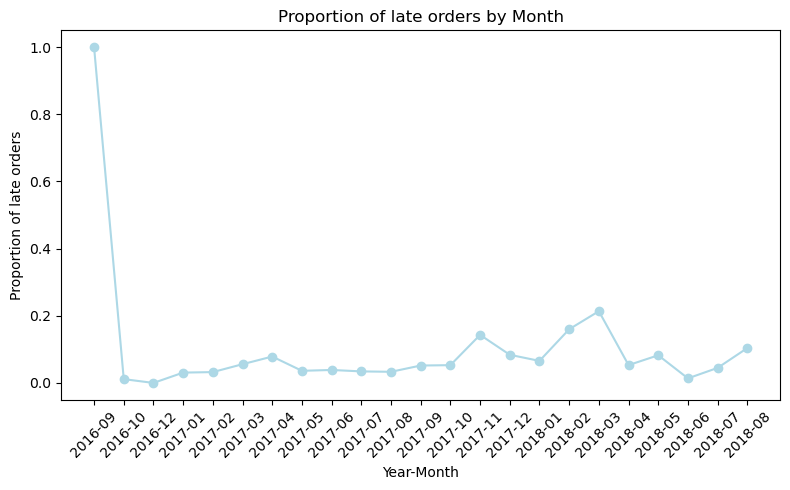

In [48]:
# Set up the figure and axis
plt.figure(figsize=(8, 5))

# Plotting the late orders proportion as a line plot
plt.plot(late_orders['year_month'], 
         late_orders['late_orders_proportion'], 
         color='lightblue', marker='o', linestyle='-')

plt.xlabel('Year-Month')
plt.ylabel('Proportion of late orders')
plt.title('Proportion of late orders by Month')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### 3. Which states or cities experience the most delays in delivery?

In [50]:
# monthly
merge_table = """
WITH merged_data AS(
SELECT *
FROM orders
INNER JOIN customers
ON orders.customer_id = customers.customer_id)
SELECT  
    customer_city,
    COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) AS late_order_counts
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY customer_city
ORDER BY late_order_counts DESC;
"""
late_orders_by_city = pd.read_sql_query(merge_table, engine)
late_orders_by_city.head(10)

,customer_city,late_order_counts
0,sao paulo,942
1,rio de janeiro,780
2,salvador,208
3,belo horizonte,166
4,porto alegre,158
5,brasilia,147
6,campinas,143
7,fortaleza,111
8,niteroi,103
9,sao goncalo,96


### Shipping Costs

#### 1. What is the average freight value per order?

In [53]:
# monthly
merge_table = """
WITH merged_data AS(
SELECT * 
FROM orders
INNER JOIN order_items
ON orders.order_id = order_items.order_id)
SELECT  CONCAT(strftime('%Y', order_purchase_timestamp), '-', strftime('%m', order_purchase_timestamp)) AS year_month,
        AVG(freight_value) AS avg_shipping_cost
FROM merged_data
WHERE order_status = 'delivered'
GROUP BY year_month
ORDER BY year_month
"""
avg_shipping_cost_by_order = pd.read_sql_query(merge_table, engine)
avg_shipping_cost_by_order.head()

,year_month,avg_shipping_cost
0,2016-09,2.830000
1,2016-10,19.698243
2,2016-12,8.720000
3,2017-01,17.184380
4,2017-02,19.924547


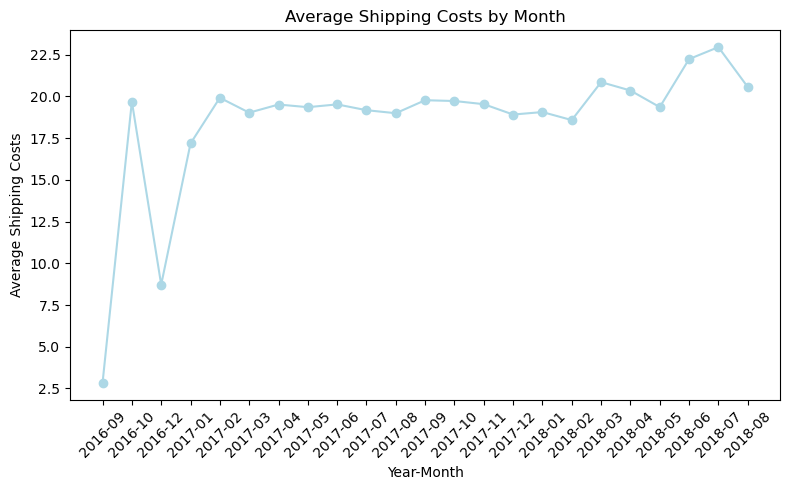

In [54]:
# Set up the figure and axis
plt.figure(figsize=(8, 5))

# Plotting the average shipping costs as a line plot
plt.plot(avg_shipping_cost_by_order['year_month'], 
         avg_shipping_cost_by_order['avg_shipping_cost'], 
         color='lightblue', marker='o', linestyle='-')

plt.xlabel('Year-Month')
plt.ylabel('Average Shipping Costs')
plt.title('Average Shipping Costs by Month')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### 2. Is there a correlation between freight value and delivery time?

In [56]:
# monthly
merge_table = """
WITH merged_data AS(
SELECT * 
FROM orders
INNER JOIN order_items
ON orders.order_id = order_items.order_id)
SELECT   JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_approved_at) AS delivery_time,
        freight_value AS shipping_cost
FROM merged_data
WHERE order_status = 'delivered'
"""
corr_delivery_time_vs_freight_value = pd.read_sql_query(merge_table, engine)
corr_delivery_time_vs_freight_value.head()

,delivery_time,shipping_cost
0,8.429144,8.72
1,12.502292,22.76
2,9.382708,19.22
3,13.196331,27.20
4,2.830938,8.72


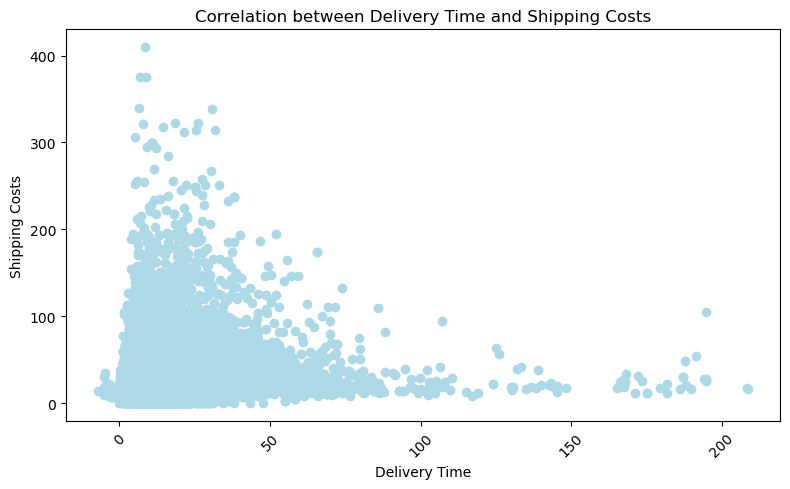

In [57]:
# Set up the figure and axis
plt.figure(figsize=(8, 5))

plt.scatter(corr_delivery_time_vs_freight_value['delivery_time'], 
         corr_delivery_time_vs_freight_value['shipping_cost'], 
         color='lightblue', marker='o')

plt.xlabel('Delivery Time')
plt.ylabel('Shipping Costs')
plt.title('Correlation between Delivery Time and Shipping Costs')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### 3. How does freight cost vary by product weight or size?

In [59]:
# monthly
merge_table = """
WITH merged_data AS(
SELECT * 
FROM orders
INNER JOIN order_items
ON orders.order_id = order_items.order_id
INNER JOIN products
ON order_items.product_id = products.product_id)
SELECT   product_weight_g AS product_weight,
        (product_height_cm * product_length_cm * product_width_cm) AS product_size,
        freight_value AS shipping_cost
FROM merged_data
WHERE order_status = 'delivered'
"""
shipping_cost_vs_size = pd.read_sql_query(merge_table, engine)
shipping_cost_vs_size.head()

,product_weight,product_size,shipping_cost
0,500.0,1976.0,8.72
1,400.0,4693.0,22.76
2,420.0,9576.0,19.22
3,450.0,6000.0,27.20
4,250.0,11475.0,8.72


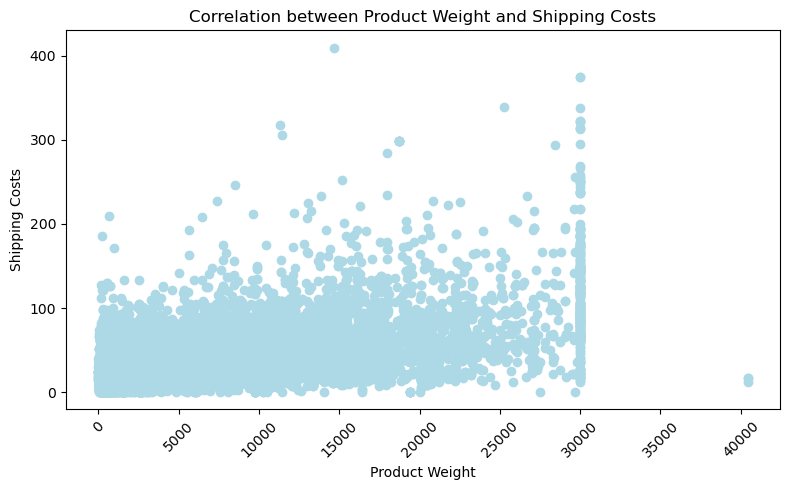

In [60]:
# Set up the figure and axis
plt.figure(figsize=(8, 5))

plt.scatter(shipping_cost_vs_size['product_weight'], 
         shipping_cost_vs_size['shipping_cost'], 
         color='lightblue', marker='o')

plt.xlabel('Product Weight')
plt.ylabel('Shipping Costs')
plt.title('Correlation between Product Weight and Shipping Costs')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

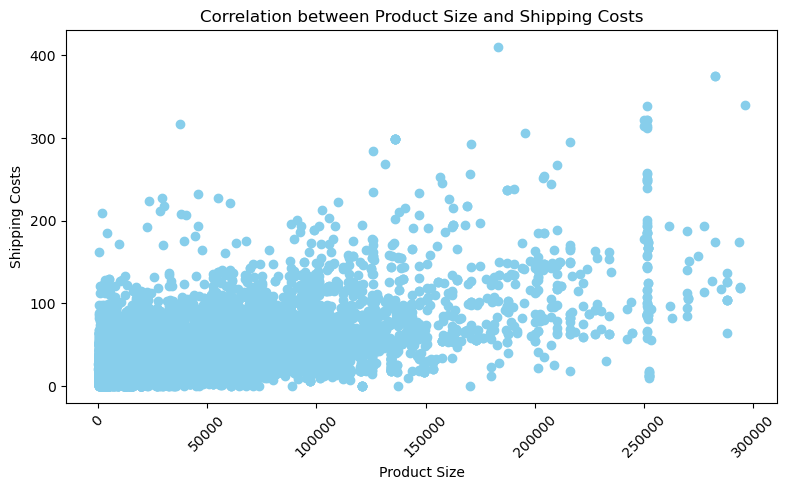

In [61]:
# Set up the figure and axis
plt.figure(figsize=(8, 5))

plt.scatter(shipping_cost_vs_size['product_size'], 
         shipping_cost_vs_size['shipping_cost'], 
         color='skyblue', marker='o')

plt.xlabel('Product Size')
plt.ylabel('Shipping Costs')
plt.title('Correlation between Product Size and Shipping Costs')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Seller Analysis

#### 1. Which sellers have the best delivery performance?

In [64]:
merge_table = """
WITH merged_data AS(
SELECT * 
FROM orders
INNER JOIN order_items
ON orders.order_id = order_items.order_id
INNER JOIN sellers
ON order_items.seller_id = sellers.seller_id
)
SELECT  
    seller_id,
    COUNT(DISTINCT order_id) AS orders_count,
    COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) AS late_orders_count,
    COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) * 1.0 / COUNT(*) AS late_orders_proportion
FROM merged_data
WHERE order_status = 'delivered' 
GROUP BY seller_id
ORDER BY late_orders_proportion ASC, orders_count DESC;
"""
sellers_with_best_perf = pd.read_sql_query(merge_table, engine)
sellers_with_best_perf.head(10)

,seller_id,orders_count,late_orders_count,late_orders_proportion
0,fc906263ca5083d09dce42fe02247800,112,0,0.0
1,9616352088dcf83a7c06637f4ebf1c80,91,0,0.0
2,f3b80352b986ab4d1057a4b724be19d0,86,0,0.0
3,b372ee768ed69e46ca8cdbd267aa7a38,63,0,0.0
4,57e632711dec9ec14ca7546769483e7e,62,0,0.0
5,e882b2a25a10b9c057cc49695f222c19,57,0,0.0
6,cc63f0dd2acba93ffed4fe9f8e0321fa,55,0,0.0
7,fa1a9dec3a9940c072684a46728bf1fc,55,0,0.0
8,3504c0cb71d7fa48d967e0e4c94d59d9,53,0,0.0
9,2b3e4a2a3ea8e01938cabda2a3e5cc79,52,0,0.0


#### 2. Which sellers contribute the most to shipping delays?

In [66]:
merge_table = """
WITH merged_data AS(
SELECT * 
FROM orders
INNER JOIN order_items
ON orders.order_id = order_items.order_id
INNER JOIN sellers
ON order_items.seller_id = sellers.seller_id
)
SELECT  
    seller_id,
    COUNT(DISTINCT order_id) AS order_counts,
    COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) AS late_order_counts,
    COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) * 1.0 / COUNT(*) AS late_orders_proportion
FROM merged_data
WHERE order_status = 'delivered' 
GROUP BY seller_id
ORDER BY late_order_counts DESC, late_orders_proportion DESC
"""
seller_with_late_orders = pd.read_sql_query(merge_table, engine)
seller_with_late_orders = seller_with_late_orders.head(10)

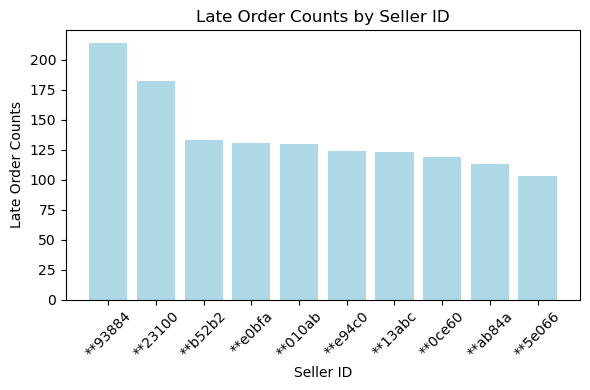

In [67]:
plt.figure(figsize=(6, 4))

# Plotting the order counts
plt.bar(seller_with_late_orders['seller_id'], 
        seller_with_late_orders['late_order_counts'], 
        color='lightblue')

plt.xlabel('Seller ID')
plt.ylabel('Late Order Counts')
plt.title('Late Order Counts by Seller ID')

# Custom x-ticks labels to be the last 5 digits of seller_id with ** prefix
xticks = [f"**{str(seller_id)[-5:]}" for seller_id in seller_with_late_orders['seller_id']]
plt.xticks(ticks=range(len(xticks)), labels=xticks, rotation=45)

plt.tight_layout()
plt.show()

#### 3. Are specific sellers concentrated in certain regions?

In [69]:
merge_table = """
SELECT  
    seller_city,
    COUNT(*) AS no_of_sellers
FROM sellers
GROUP BY seller_city
ORDER BY no_of_sellers DESC
"""
no_sellers_by_city = pd.read_sql_query(merge_table, engine)
no_sellers_by_city = no_sellers_by_city.head(10)

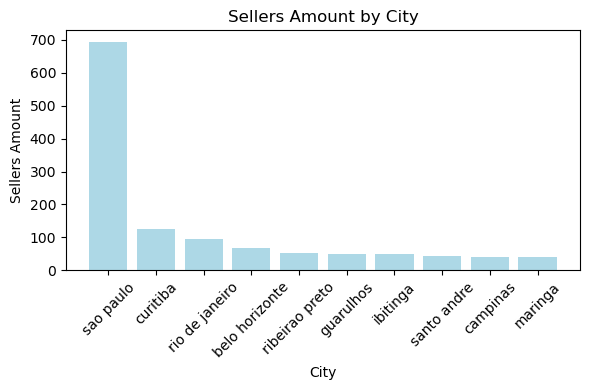

In [70]:
plt.figure(figsize=(6, 4))

# Plotting the order counts
plt.bar(no_sellers_by_city['seller_city'], 
        no_sellers_by_city['no_of_sellers'], 
        color='lightblue')

plt.xlabel('City')
plt.ylabel('Sellers Amount')
plt.title('Sellers Amount by City')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()